In [21]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle
import kipoiseq
from itertools import combinations
import scipy
import os
import gene as bgene
import shuffle
from scipy.stats import pearsonr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
seq_parser = utils.SequenceParser('../data/GRCh38.primary_assembly.genome.fa')

In [23]:
x = seq_parser.extract_seq_centered('chr1', 10000000, '+', 10)

In [26]:
x_1 = shuffle.dinuc_shuffle(x)

In [27]:
x

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [29]:
x_1

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [43]:

x_2 = shuffle.dinuc_shuffle(x, seed=1)
x_2

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [40]:
x_3 = shuffle.dinuc_shuffle(x, rng=np.random.RandomState(1))


In [44]:
np.array_equal(x_2, x_3)

True

In [54]:
result_dir = '../results/gencode_tss_predictions/borzoi/'
i, row = next(tss_df.iterrows())
pred = utils.read_pickle(f'{result_dir}/{utils.get_summary(row)}.pickle')['cage'][0].mean(axis=1)

In [58]:
cell_lines = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
column_names = cell_lines
cage_tracks = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in cell_lines)]

cell_line_info = {}
for target_cell_line in cell_lines:
    cell_line_info[target_cell_line] = {}
    targets = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() == target_cell_line)]
    
    
    cell_line_info[target_cell_line]['output'] = [np.argwhere(np.array(cage_tracks) == t).flatten()[0] for t in
                                                  targets]
    cell_line_info[target_cell_line]['target'] = '&'.join([str(t) for t in targets])

In [61]:
for cell_line, v in cell_line_info.items():
    indeces = v['output']
    print(pred[indeces].mean()) # average across same cell line tracks



2.441
32.6
0.628


In [63]:
row

Chromosome                             chr2
Start                             135052307
gene_name                          RAB3GAP1
gene_id                  ENSG00000115839.19
Strand                                    +
K562 ENCODE, biol_                  0.62793
GM12878 ENCODE, biol_                   NaN
PC-3                                    NaN
Name: 6110, dtype: object

In [5]:
tss_df[tss_df['gene_name']=='RAB3GAP1']

,Chromosome,Start,gene_name,gene_id,Strand,PC-3,GM12878,K562
6107,chr2,135052291,RAB3GAP1,ENSG00000115839.19,+,126.516533,NaN,NaN
6107,chr2,135052291,RAB3GAP1,ENSG00000115839.19,+,NaN,394.217743,NaN
6107,chr2,135052291,RAB3GAP1,ENSG00000115839.19,+,NaN,NaN,238.393433


In [8]:
borzoi_df = pd.concat(pd.read_csv(f, index_col='Unnamed: 0') for f in glob.glob(f'../results/gencode_tss_predictions/borzoi/*selected_tss.csv'))




In [9]:
enformer_df = pd.concat(pd.read_csv(f, index_col='Unnamed: 0') for f in glob.glob(f'../results/gencode_tss_predictions/enformer/*selected_tss.csv'))


In [14]:
borzoi_df.merge(enformer_df, on='gene_name')['gene_name'].unique().shape

(10810,)

In [5]:
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
cage_tracks = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                               'GM12878 ENCODE, biol_',
                                                               'PC-3'])]

In [30]:
model = custom_model.Borzoi('../data/borzoi/*/*', [5,6,7], aggregate=True)

Adding models:
['../data/borzoi/f0/model0_best.h5', '../data/borzoi/f1/model0_best.h5', '../data/borzoi/f2/model0_best.h5', '../data/borzoi/f3/model0_best.h5']


In [34]:
cage_bins = list(np.arange(model.target_lengths // 2-4, model.target_lengths // 2+4, 1))

In [35]:
model.bin_index = cage_bins

In [36]:
pred = model.predict(np.empty((1, model.seq_length, 4)))

In [37]:
pred.shape

(1, 8, 3)

In [47]:
column_names = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']

In [51]:
target_cell_lines = ['K562 ENCODE, biol_',
                                                               'GM12878 ENCODE, biol_',
                                                               'PC-3']
cage_tracks = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in target_cell_lines)]
    

In [56]:
cage_tracks = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                               'GM12878 ENCODE, biol_',
                                                               'PC-3'])]

In [68]:
cell_line_info = {}
for target_cell_line in target_cell_lines:
    cell_line_info[target_cell_line] = {}
    targets = [i for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() == target_cell_line)]
    
    cell_line_info[target_cell_line]['targets'] = targets
    cell_line_info[target_cell_line]['output'] = [np.argwhere(np.array(cage_tracks) == t).flatten()[0] for t in targets]

In [69]:
cell_line_info

{'K562 ENCODE, biol_': {'targets': [872, 873], 'output': [4, 5]},
 'GM12878 ENCODE, biol_': {'targets': [870, 871], 'output': [2, 3]},
 'PC-3': {'targets': [298, 299], 'output': [0, 1]}}

In [75]:
'&'.join([str(t) for t in targets])

'298&299'

In [19]:
model = custom_model.Borzoi('../data/borzoi/*/*', [0], [1], aggregate=True)

Adding models:
['../data/borzoi/f0/model0_best.h5', '../data/borzoi/f1/model0_best.h5', '../data/borzoi/f2/model0_best.h5', '../data/borzoi/f3/model0_best.h5']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-11-20 09:38:55.942315: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 09:38:56.314261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79005 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:47:00.0, compute capability: 8.0


In [20]:
model.target_lengths


16352

In [ ]:
for i, row in tqdm(tss_df.iterrows(), total=N):

In [18]:
pd.read_csv(f'../data/borzoi_targets_human.txt', sep='\t')

,Unnamed: 0,identifier,file,clip,clip_soft,scale,sum_stat,strand_pair,description
0,0,CNhs10608+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,1,CAGE:Clontech Human Universal Reference Total ...
1,1,CNhs10608-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,0,CAGE:Clontech Human Universal Reference Total ...
2,2,CNhs10610+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,3,CAGE:SABiosciences XpressRef Human Universal T...
3,3,CNhs10610-,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,2,CAGE:SABiosciences XpressRef Human Universal T...
4,4,CNhs10612+,/home/drk/tillage/datasets/human/cage/fantom/C...,768,384,1.00,sum,5,CAGE:Universal RNA - Human Normal Tissues Bioc...
...,...,...,...,...,...,...,...,...,...
7606,7606,GTEX-13FTX-1026-SM-5J2O5.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7606,RNA:uterus
7607,7607,GTEX-1MA7W-1526-SM-DHXKS.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7607,RNA:uterus
7608,7608,GTEX-11EMC-1926-SM-5A5JU.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7608,RNA:vagina
7609,7609,GTEX-12WSB-2426-SM-5EGJC.1,/home/drk/tillage/datasets/human/rna/recount3/...,768,384,0.01,sum_sqrt,7609,RNA:vagina


In [2]:
res_paths = glob.glob('../results/gencode_tss_predictions/borzoi/*pickle')

In [511]:
for res_path in res_paths:
    enf_res_path = os.path.isfile(res_path.replace('borzoi', 'enformer').replace('pickle', 'npy'))
    

In [510]:
res_path.replace('borzoi', 'enformer').replace('pickle', 'npy')

'../results/gencode_tss_predictions/enformer/BPNT1_chr1_220090462_-.npy'

In [8]:

target_df_path = '../data/borzoi_targets_human.txt'
rna_track_labels = ['K562', 'GM12878', 'PC-3']

rna_track_groups = utils.map_indeces_to_labels_borzoi(rna_track_labels, 'RNA', target_df_path)
cage_track_labels = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
cage_track_groups = utils.map_indeces_to_labels_borzoi(cage_track_labels, 'CAGE', target_df_path)

In [487]:
coverage_summary = []

for cell in rna_track_labels:
    per_cell_pos = []
    
    for res_path in res_paths:
        res = utils.read_pickle(res_path)
        rna = res['rna'][0] 
        
        cell_specific_rna = rna[:, np.array(rna_track_groups[cell]['idx'])]
        per_cell_pos.append(cell_specific_rna.sum(axis=0)) 
    df = pd.DataFrame(per_cell_pos).T
    df['cell'] = cell
    df['original_track_idx'] = rna_track_groups[cell]['original_track_idx']
    df['strand'] = rna_track_groups[cell]['strand']
    df['output_idx'] = rna_track_groups[cell]['idx']
    coverage_summary.append(df)
coverage_summary = pd.concat(coverage_summary)
    


In [505]:
N_seqs = len(res_paths)

In [488]:
coverage_summary.head(2)

,0,1,2,3,4,5,6,7,8,9,...,52018,52019,52020,52021,52022,52023,cell,original_track_idx,strand,output_idx
0,0.818848,3.710938,2.109375,59.06250,286.750000,1051.0000,218.375000,435.75,535.0000,119.812500,...,0.385498,55.906250,403.50000,1.438477,330.250,246.125000,K562,6122,+,10
1,0.046234,0.245605,0.065674,0.99707,3.640625,10.3125,2.089844,37.00,54.9375,3.509766,...,0.021225,1.665039,33.21875,1.215820,10.625,0.958984,K562,6123,-,11


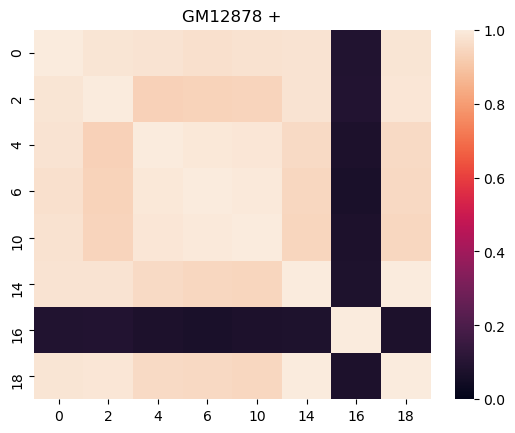

[6]


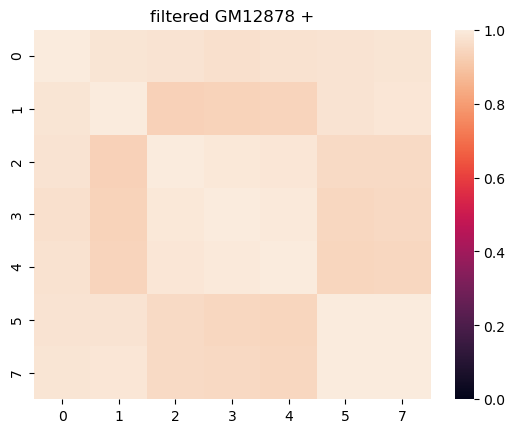

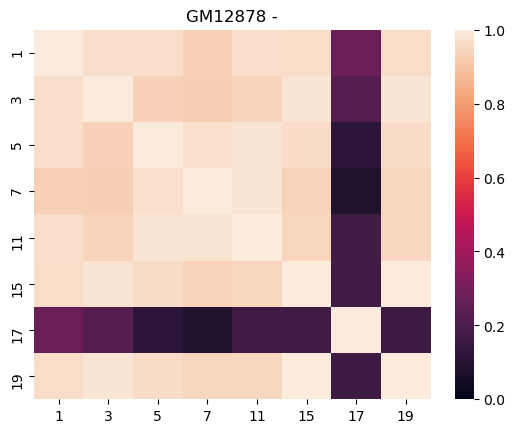

[6]


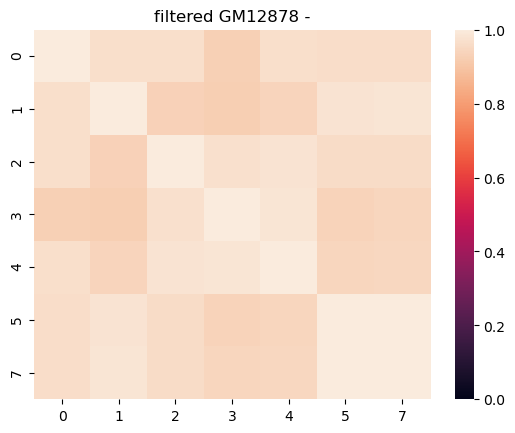

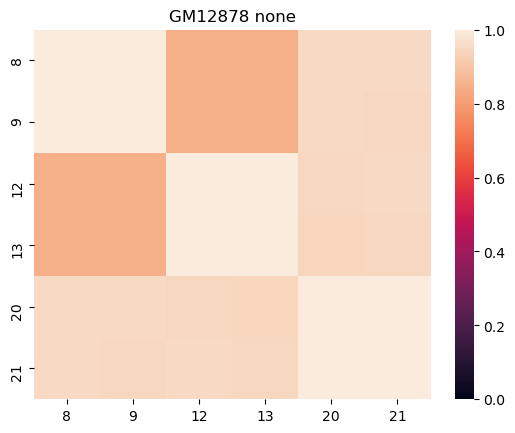

[]


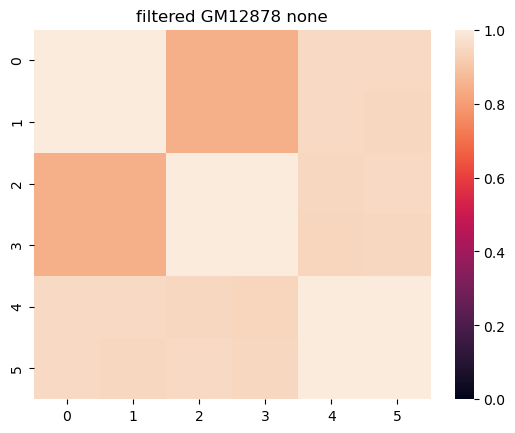

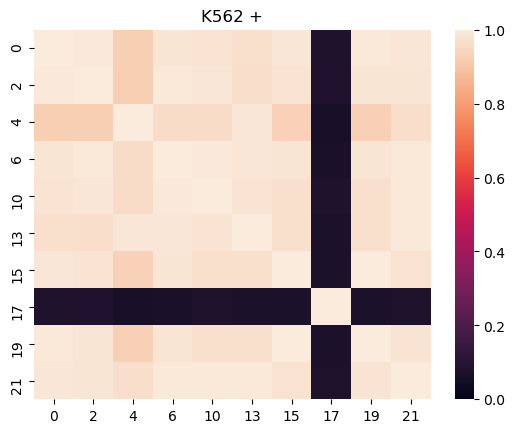

[7]


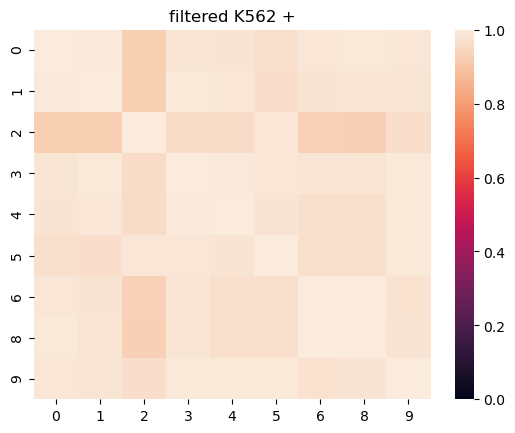

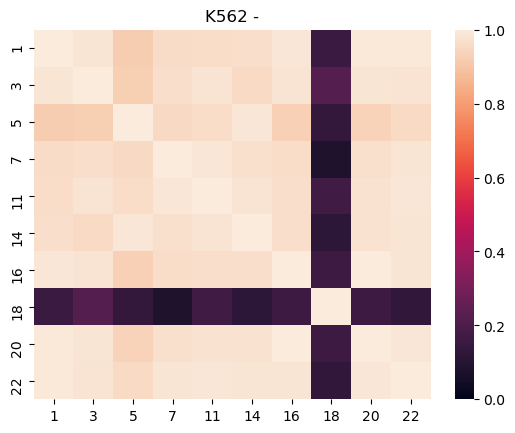

[7]


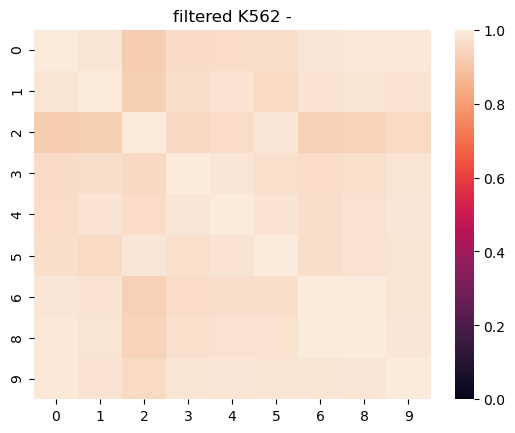

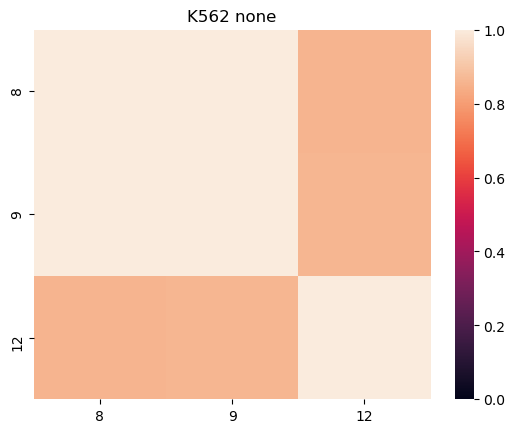

[]


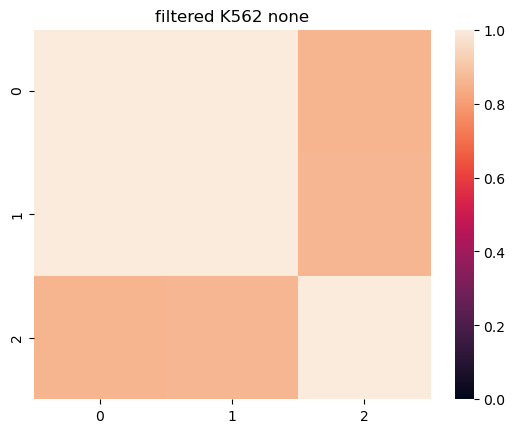

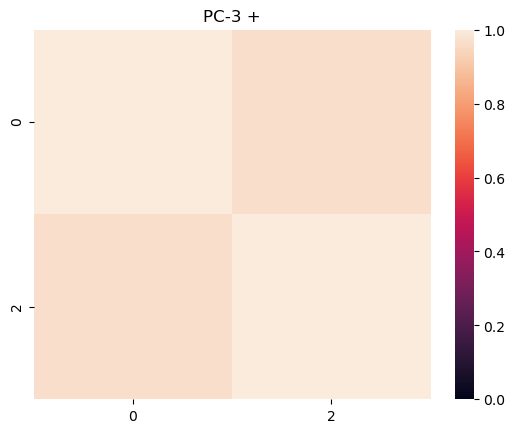

[]


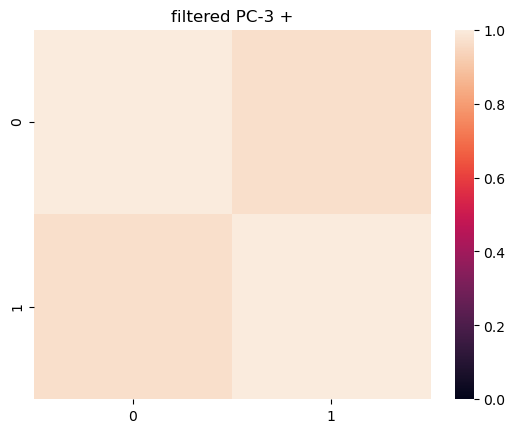

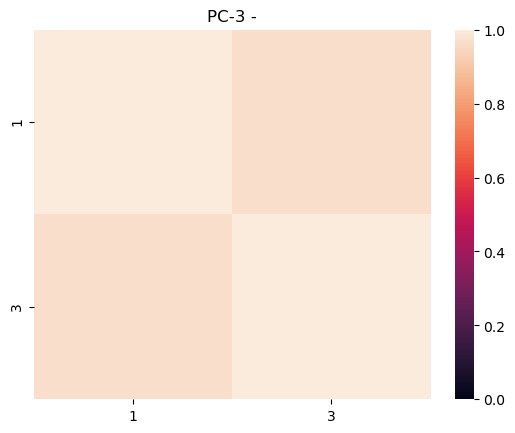

[]


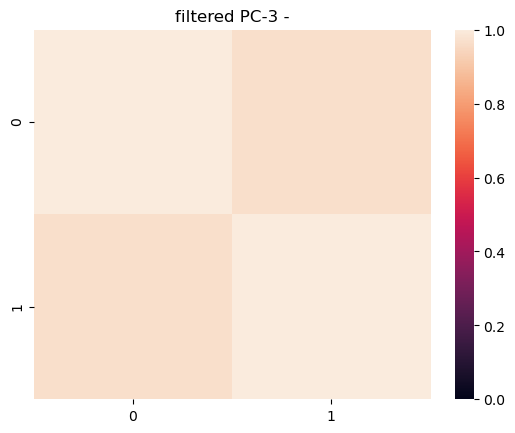

In [489]:
filtered_dfs = []
for (cell, strand), df in coverage_summary.groupby(['cell', 'strand']):
    corr_df = df.iloc[:,:N_seqs].T.corr()
    sns.heatmap(corr_df, vmin=0, vmax=1)
    plt.title(f'{cell} {strand}')
    plt.show()
    bad_rows = np.argwhere((corr_df<0.5).sum(axis=0) == df.shape[0]-1).flatten()
    print(bad_rows)
    if bad_rows.shape:
        filtered_df = df.reset_index(drop=True).drop(bad_rows)
        sns.heatmap(filtered_df.iloc[:,:N_seqs].T.corr(),vmin=0, vmax=1)
        plt.title(f'filtered {cell} {strand}')
        plt.show()
        filtered_dfs.append(filtered_df)
    else:
        filtered_dfs.append(df)
    
filtered_dfs = pd.concat(filtered_dfs)

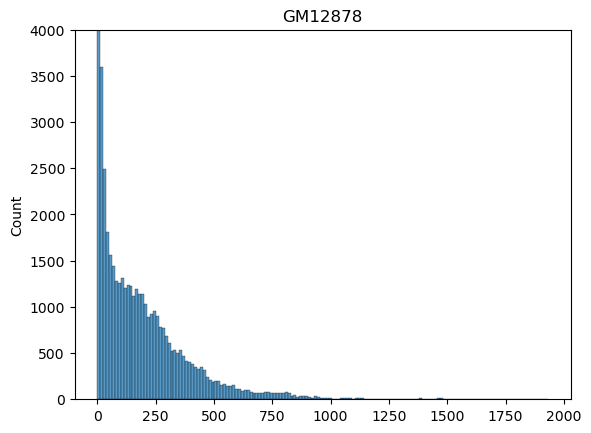

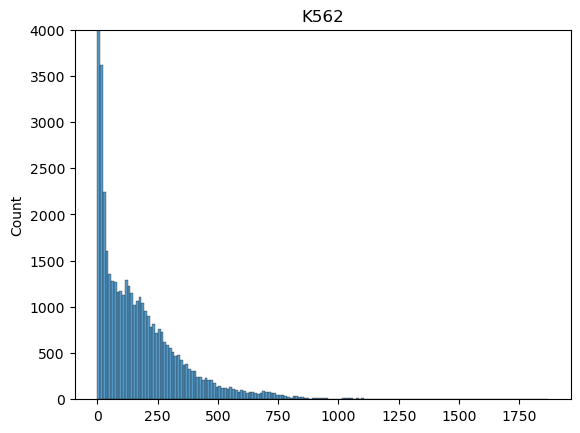

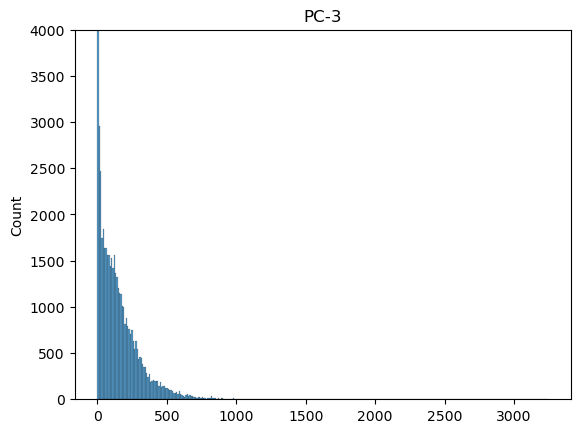

In [491]:
for cell, df in filtered_dfs.groupby('cell'):
    x = df.iloc[:,:N_seqs].mean(axis=0).values.astype(np.float64)
    sns.histplot(x)
    plt.title(cell)
    plt.ylim(0, 4000)
    plt.show()

In [496]:
x.argsort()[::-1][:10000]

array([ 4853, 36727, 14215, ..., 14853, 13052, 22347])

In [515]:
enf_res_path = res_path.replace('borzoi', 'enformer').replace('pickle', 'npy')

In [517]:
np.load(enf_res_path).shape

(896, 5313)

In [514]:
enf_res_path

True

In [21]:
pred = utils.read_pickle(f'../results/gencode_tss_predictions/borzoi/A1BG_chr19_58353492_-.pickle')

In [23]:
pred['cage'].shape

(1, 8, 6)

In [44]:

pred = utils.read_pickle(f'../results/gencode_tss_predictions/borzoi/A1BG_chr19_58353492_-.pickle')['cage'][0].mean(axis=1)
for cell_line, indeces in cell_lines.items():
    x = pred[indeces].mean()

In [46]:
x

0.0396

In [25]:
target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')


In [30]:
cage_tracks = [t for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
                                                               'GM12878 ENCODE, biol_',
                                                               'PC-3'])]

In [38]:
column_names = ['K562 ENCODE, biol_', 'GM12878 ENCODE, biol_', 'PC-3']
cell_line_groups = [t for i, t in enumerate(target_df['description']) if
               ('CAGE' in t) and (t.split(':')[-1].strip() in column_names)]
cell_lines = {}
for i, df in pd.DataFrame(cell_line_groups).groupby(0):
    cell_lines[i] = list(df.index)

In [40]:
len(cell_lines)

3

In [ ]:
for cell, enf_id in {'K562 ENCODE, biol_': 5111,  'GM12878 ENCODE, biol_': 5110, 'PC-3': 4824}.items():
    per_cell_pos = []
    per_cell_enf = []
    cell_list = []
    
    for res_path in tqdm(res_paths):
        cage = utils.read_pickle(res_path)['cage'][0] 
        
        enf_res = np.load(res_path.replace('borzoi', 'enformer').replace('pickle', 'npy'))
                          
        cell_specific_rna = cage[:, np.array(cage_track_groups[cell]['idx'])]
        per_cell_pos.append(cell_specific_rna.mean()) 
    
    
        ### enformer
        per_cell_enf.append(enf_res[447:449, enf_id].mean())
        cell_list.append(cell)
        
    sns.scatterplot(x=per_cell_enf, y=per_cell_pos, alpha=0.3)
    plt.show()

 10%|████████▊                                                                               | 5238/52024 [00:16<02:00, 389.48it/s]

<Axes: >

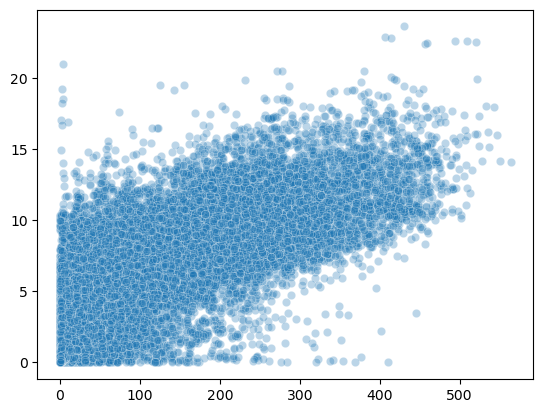

In [48]:
tss_df = pd.concat(pd.read_csv(f, index_col='Unnamed: 0') for f in glob.glob(f'../results/gencode_tss_predictions/enformer/*selected_tss.csv'))
print(tss_df.shape)
tss_df = tss_df.iloc[:, :-3].drop_duplicates()


tss_df.shape

(30000, 8)


(14256, 5)

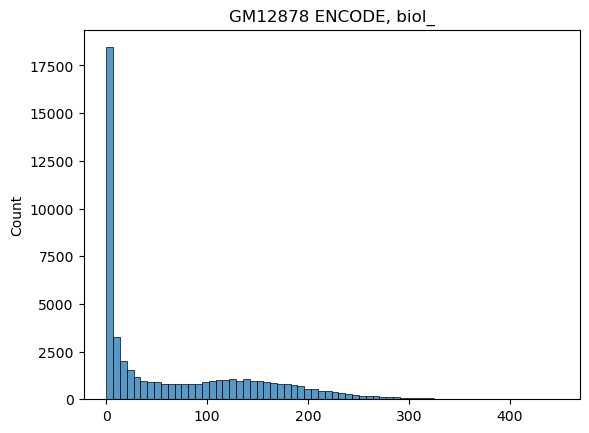

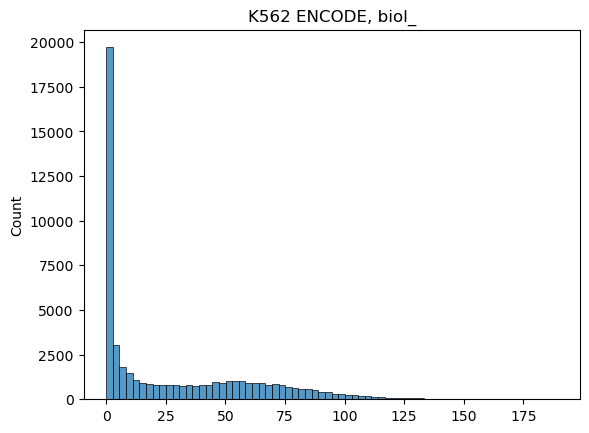

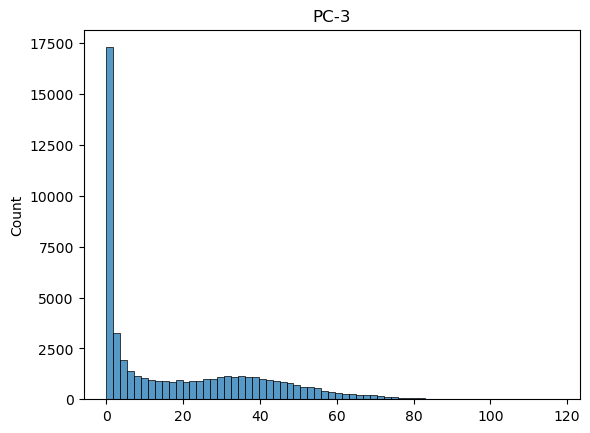

In [507]:
for cell, df in coverage_summary.groupby('cell'):
    x = df.iloc[:,:N_seqs].mean(axis=0).values.astype(np.float64)
    sns.histplot(x)
    plt.title(cell)
    # plt.ylim(0, 4000)
    plt.show()

0         0.108459
1         0.343018
2         0.221802
3         0.195312
4        31.765625
           ...    
52019    12.625000
52020    26.718750
52021     1.081055
52022    31.453125
52023     0.941406
Length: 52024, dtype: float16

In [ ]:
for (cell, strand), df in coverage_summary.groupby(['cell', 'strand']):
    corr_df = df.iloc[:,:52023+1].T.corr()
    sns.heatmap(corr_df, vmin=0, vmax=1)
    plt.title(f'{cell} {strand}')
    plt.show()
    bad_rows = np.argwhere((corr_df<0.5).sum(axis=0) == df.shape[0]-1).flatten()
    print(bad_rows)
    if bad_rows.shape:
        filtered_df = df.reset_index(drop=True).drop(bad_rows)
        sns.heatmap(filtered_df.iloc[:,:52023+1].T.corr(),vmin=0, vmax=1)
        plt.title(f'filtered {cell} {strand}')
        plt.show()
        filtered_dfs.append(filtered_df)
    else:
        filtered_dfs.append(df)
    
filtered_dfs = pd.concat(filtered_dfs)

In [54]:
# target_df = pd.read_csv('../data/borzoi_targets_human.txt', sep='\t')
# cage_tracks = [i for i, t in enumerate(target_df['description']) if
#                ('CAGE' in t) and (t.split(':')[-1].strip() in ['K562 ENCODE, biol_',
#                                                                'GM12878 ENCODE, biol_',
#                                                                'PC-3'])]

# rna_tracks = [i for i, t in enumerate(target_df['description']) if
#               ('RNA' in t) and (t.split(':')[-1].strip() in ['K562',
#                                                              'GM12878',
#                                                              'PC-3'])]
# target_df.iloc[cage_tracks+rna_tracks].to_csv('../data/borzoi_cage_rna_tracks.csv')
model = custom_model.Borzoi('../data/borzoi/*/*', cage_tracks, rna_tracks, aggregate=True)

Adding models:
['../data/borzoi/f0/model0_best.h5', '../data/borzoi/f1/model0_best.h5', '../data/borzoi/f2/model0_best.h5', '../data/borzoi/f3/model0_best.h5']
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-11-16 09:36:38.948340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 09:36:39.958672: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 69493 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:47:00.0, compute capability: 8.0


In [440]:
transcriptome = bgene.Transcriptome('../data/gencode.v44.basic.annotation.gtf')
fasta_path = f'../data//GRCh38.primary_assembly.genome.fa'


In [441]:
seq_parser = utils.SequenceParser(fasta_path)

In [442]:
tss_df = pd.read_csv('../results/tss_positions.csv')

In [473]:
chrom, center_pos = res_path.split('/')[-1].split('_')[1:3]
center_pos = int(center_pos)

In [474]:
tss_df[tss_df['Start']==center_pos]['gene_name']

19080    SOD2
Name: gene_name, dtype: object

In [475]:
res_path

'../results/gencode_tss_predictions/borzoi/SOD2_chr6_159693228_-.pickle'

In [476]:
row = tss_df[tss_df['Start'] == center_pos].iloc[0]

In [477]:
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if row['gene_id'] in gene_key]

In [478]:
gene = transcriptome.genes[gene_keys[0]]

In [479]:
start = center_pos - model.seq_length // 2
end = center_pos + model.seq_length // 2
seq_out_start = start + model.model_strides * model.target_crops
seq_out_len = model.model_strides * model.target_lengths
gene_slice = gene.output_slice(seq_out_start, seq_out_len, model.model_strides, False)

In [480]:
sequence_one_hot = seq_parser.extract_seq_centered(chrom, center_pos, gene.strand, model.seq_length)[np.newaxis]

In [481]:
preds = []
for j, m in enumerate(model.models):
    preds.append(m(sequence_one_hot)[:, None, ...].astype("float16"))
preds = np.concatenate(preds, axis=1)

In [482]:
rna_tracks = [i for i, t in enumerate(target_df['description']) if
              ('RNA' in t) and (t.split(':')[-1].strip() =='PC-3'
                                                             )]

In [483]:
mean_preds = preds[0].mean(axis=0)[:, rna_tracks]
max_pred = mean_preds.max()

In [484]:
mean_preds.shape

(16352, 4)

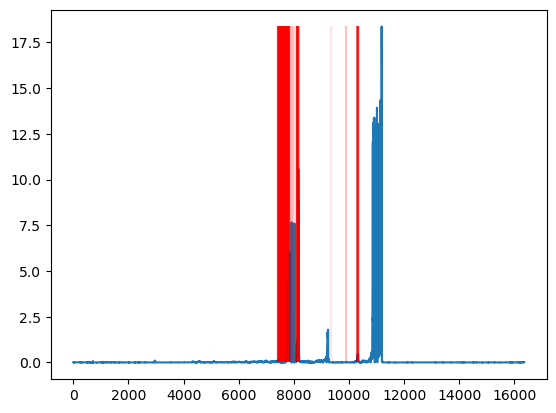

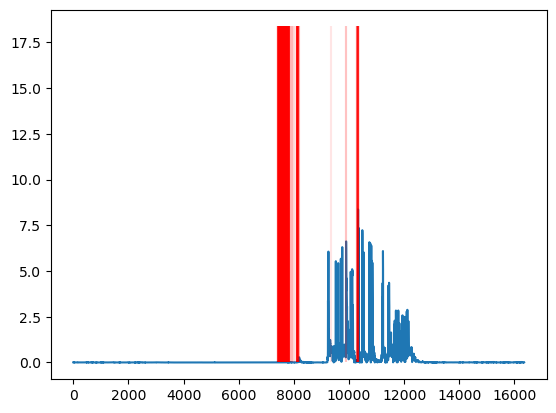

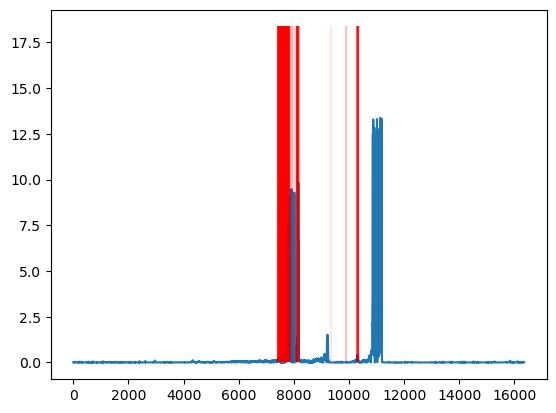

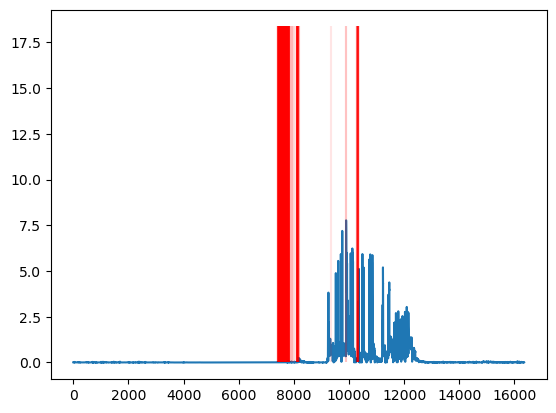

In [485]:
for m in mean_preds.T:
    plt.plot(m[::-1])
    for g in gene_slice:
        plt.vlines(g, 0, max_pred, color='r', alpha=0.05)
    plt.show()

In [153]:
rna_tracks = [i for i, t in enumerate(target_df['description']) if
              ('RNA' in t) and (t.split(':')[-1].strip() =='PC-3'
                                                             )]

rna_tracks

[6802, 6803, 7086, 7087]

In [149]:
rna_track_groups

{'GM12878': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  20,
  21,
  24,
  26,
  29,
  30,
  31,
  32,
  43,
  44,
  45,
  48],
 'K562': [10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  22,
  23,
  25,
  27,
  28,
  35,
  36,
  37,
  38,
  41,
  42,
  46,
  47],
 'PC-3': [33, 34, 39, 40]}